# A Movie behind a Script


In [3]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.types import *
import pyspark.sql.functions as psf
from pyspark.sql.utils import AnalysisException

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns

#os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.10:0.4.1 pyspark-shell'



In [4]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.session.timeZone', 'UTC')
sc = spark.sparkContext
sqlContext = SQLContext(sc)

# Overview of datasets

The OpenSubtitles dataset is a compressed cluster of folders containing XML files. Each XML file is split into a script portion with the subtitles of the movie and a metadata portion with additional information about the movie or show. The name of one of the parent folders of the XML file is the corresponding IMDb identifier of the movie or show, thus allowing us to extract additional information from the IMDb dataset.

## IMDb Dataset

We have at our disposal the IMDb ratings and basics dataset. Where we have useful information to filter our subtitles dataset as we only want to analyze movies 

In [12]:
df_basics = spark.read.parquet("parquets/basics.parquet")
df_basics.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: double (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [13]:
df_ratings = spark.read.parquet("parquets/ratings.parquet")
df_ratings.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- averageRating: float (nullable = true)
 |-- numVotes: integer (nullable = true)



In [6]:
# Function to split genres
udf_split = psf.udf(lambda s: s.split(',') if s is not None else "", ArrayType(StringType()))

## OpenSubtitles dataset

The dataset consists of 31 GB of XML files distributed in the following file structure: 

```
├── opensubtitle
│   ├── OpenSubtitles2018
│   │   ├── Year
│   │   │   ├── Id
│   │   │   │   ├── #######.xml.gz
│   │   │   │   ├── #######.xml.gz
│   ├── en.tar.gz
│   ├── fr.tar.gz
│   ├── zh_cn.tar.gz
```
where
- `######` is a 6-digit unique identifier of the file on the OpenSubtitles dataset.
- `Year` is the year the movie or episode was made.
- `Id` is a 5 to 7 digit identifier (if it's 7-digit it's also an IMDb identifier).

The subtitles are provided in different languages. We only analyze the `OpenSubtitles2018` folder and it's the only folder we detail.

The decompressed XML files vary in size, ranging from 5KB to 9000KB sized files.

## XML Files

Each XML file is split into a `document` and `metadata` section.

### Subtitles

The `document` section contains all the subtitles and its general structure is the following:

```
├── s
│   ├── time: Integer
│   ├── w: String
```

An example snippet of an XML file:

```xml
  <s id="1">
    <time id="T1S" value="00:00:51,819" />
    <w id="1.1">Travis</w>
    <w id="1.2">.</w>
    <time id="T1E" value="00:00:53,352" />
  </s>
```

The subtitles in each XML file are stored by **blocks** denoted by `s` with a unique `id` attribute (integers in increasing order starting at 1).  

Each block (`<s id="1">` for instance) has a:  

1. Set of timestamps (denoted by `time`) with
 - A timestamp `id` attribute that can take two different formats: `T#S` or `T#E`, where _S_ indicates _start_, _E_ indicates _end_ and _#_ is an increasing integer. 
 - A `value` attribute which has the format `HH:mm:ss,fff`.

2. Set of words (denoted by `w`) with
 - an `id` attribute that is simply an increasing number of decimal numbers of the format `X.Y` where X is the string id and Y is the word id within the corresponding string
 - a non-empty `value` attribute that contains a token: a word or a punctuation character. 

It sometimes also has an `alternative`, `initial` and `emphasis` attribute.  

 - The `initial` attribute generally corresponds to slang words or mispronounced words because of an accent such as _lyin'_ instead of _lying_.  
 - The `alternative` attribute is another way of displaying the subtitle for example _HOW_ instead of _how_.
 - The `emphasis` attribute is a boolean.

### Metadata

The `metadata` section has the following structure:

```
├── Conversion
│   ├── corrected_words: Integer
│   ├── sentences: Integer
│   ├── tokens: Integer
│   ├── encoding: String (always utf-8)
│   ├── unknown_words: Integer
│   ├── ignored_blocks: Integer
│   ├── truecased_words: Integer
├── Subtitle
│   ├── language: String
│   ├── date: String
│   ├── duration: String
│   ├── cds: String (presented as #/# where # is an int)
│   ├── blocks: Integer
│   ├── confidence: Double
├── Source
│   ├── genre: String[] (up to 3 genres)
│   ├── year: Integer
│   ├── duration: Integer (in minutes)
│   ├── original: String
│   ├── country: String
```

We note that some XML files may not have all the entries. 
We can use the metadata to obtain additional information about the movie or show's subtitles and compute certain statistics. 

## Document dataframe

## Exploration

Going through the dataset we notice a few things:

1. The dataset has meaningless folders. For example, the folder 1858/ is empty.
2. Dataset contains XML files that are not related to movies or TV shows. For example, the folder 666/ contains Justin Bieber song subtitles.  
3. Trailer of films can be present in the dataset. For example, the folder 2018/ we found for example Black Panther teaser trailer subtitles.
4. Each movie might have more than 1 subtitle file.
5. Some subtitle files contain text that is not related to the movie, like credits to the person who made the subtitles.
7. Each block may have an arbitrary number (including 0) of timestamps associated to it.

To solve 1,2 and 3 we decide to take only files associated with valid imdb id's of movies with more than 5000 reviews.

To solve point 4, we simply take the first one.

To solve point 6, we keep movies that have a correct IMDb identifier. Hence, all the files in folders that don't have a 7-digit folder name are dropped.

To solve point 7, we decide not to associate a timestamp to each word.
 
We extract the desired dataset information into an initial parquet file using the script `parquet2.py` and then from this dataset we extract all the information for the data analysis. In the following section we specify how we decided to shape the dataset.

## Putting it all together

After doing an analysis of the files and considering the statistics we want to obtain taking the size of our data into account, we decide to load the metadata and subtitles directly into 1 dataframe where we manipulate it as before. We decide not to extract all tokens at first as it would induce into very heavy computations. We store the text in an array of subtitles where each subtitle is an array of tokens.

In [8]:
# imdb_id = '6464116'
# df_document_example = sqlContext.read.format('com.databricks.spark.xml')\
#                                      .options(rowTag='document') \
#                                      .load('sample_dataset/2017/6464116/6887453.xml.gz')
# df_document_example.printSchema()
# df_document_example.show()

To avoid confusion, we will set some naming conventions. We will refer to certain attributes as follows:

- The `s` array as **blocks**
- An element of blocks, as a **block**.
- The `w` array as **elements**
- An element of elements, as **element**.
- `_VALUE` as a **token**
- A **subtitle** is a list of tokens

### Dataframe manipulation

We define a function that retrieves the tokens from the elements (`w` array) and returns an array of subtitles, where each subtitle is a list of tokens.

In [7]:
def to_subtitles_array(sentences):
    """Function to map the elements (a struct containing tokens)
    to a list of list of tokens """
    s_list = []
    if sentences is None:
        return s_list
    for words in sentences:
        w_list = []
        if words and "w" in words and words["w"]:
            for w in words["w"]:
                if '_VALUE' in w and w['_VALUE']:
                    w_list.append(w['_VALUE'])
                
            s_list.append(w_list)

    return s_list

Here we define a couple of udf functions we will later use for the manipulation of our dataset

In [8]:
# Transform to spark function
udf_subtitles_array = psf.udf(to_subtitles_array, ArrayType(ArrayType(StringType())))
# Convert array of words into a single string
udf_sentence = psf.udf(lambda x: ' '.join(x), StringType())

In [9]:
# Check correct schema
def has_correct_schema(df):
    arguments = [
                 "meta.conversion.sentences",
                 "meta.source.year", 
                 "meta.subtitle.blocks",
                 "meta.subtitle.duration",
                 "meta.subtitle.language",
                 "s"]
    for col in arguments:
        try:
            df[col]
        except AnalysisException:
            return False
    return True

schema_films = StructType([StructField('tconst', StringType(), False),
                               StructField('num_sentences', LongType(), True),
                               StructField('year', LongType(), True),
                               StructField('blocks', LongType(), True),
                               StructField('subtitle_mins', DoubleType(), True),
                               StructField('subtitles', ArrayType(ArrayType(StringType())), True)])

The function below structures our data to the format we want to then process all the queries we need: We link the movie with the proper imdbID, we get all the subtitles, change the subtitle duration to be in seconds (We assume for this that they all have the same format and after exploring the dataset we know the vast majority does).

In [10]:
#has_correct_schema(df_document_example)

In [11]:
def clean_df(df_document, imdb_id):
    """Restructures and selects the columns of a dataframe of an XML
    file with its corresponding IMDB Id"""
    # Create IMDb ID and subtitles column
    df_film_sentences = df_document.withColumn("tconst", psf.lit("tt" + imdb_id))\
                                   .withColumn("subtitles", udf_subtitles_array("s"))
    
    # Select metadata and previously created columns
    df_result = df_film_sentences.selectExpr("tconst",
                                             "meta.conversion.sentences as num_sentences",
                                             "meta.source.year", 
                                             "meta.subtitle.blocks",
                                             "meta.subtitle.duration as subtitle_duration",
                                             "meta.subtitle.language",
                                             "subtitles")
    # Split genre column and convert subtitle duration to seconds
    df_result = df_result.withColumn("subtitle_mins", 
                                     psf.unix_timestamp(df_result.subtitle_duration, "HH:mm:ss,SSS") / 60)
    # Discard redundant columns
    df_result =  df_result.select("tconst", 
                                  "num_sentences", 
                                  "year", 
                                  "blocks", 
                                  psf.when(psf.col("subtitle_mins") > 0, psf.col("subtitle_mins"))\
                                     .otherwise(None)\
                                     .alias("subtitle_mins"), 
                                  "subtitles")
    return df_result

Applying it on the example XML file, we see how our corresponding schema is much more simple.

In [12]:
# df_document_example = clean_df(df_document_example, imdb_id)
# df_document_example.printSchema()
# df_document_example.show()

We generalize what we have done so far. We would like to create a dataframe for several XML files, so we define a function that does this.

In [13]:
def load_df(path):
    """Load an XML subtitles file into a dataframe"""
    df_film = sqlContext.read.format('com.databricks.spark.xml')\
                             .options(rowTag='document')\
                             .load(path)
    return df_film

The code below creates a dataframe for all the XML files in the sample dataset. We will later expand it to cover a bigger quantity of films. We call it `df_films` because it contains all the information for each film/show in our datasets.

In [14]:
#path = "sample_dataset/"
# Create empty dataframe with same schema


#df_films = spark.createDataFrame([], schema_films)
#film_list = []
#for year in os.listdir(path):
 #   if not year.startswith('.'):
  #      for imdb_id in os.listdir(path + year):
   #         if not imdb_id.startswith('.'):
    #            current_path = path + year + "/" + imdb_id
     #           for idx, file in enumerate(os.listdir(current_path)):
      #                  # Create a dataframe for each file
       #                 df_document = load_df(current_path + '/' + file)
        #                if has_correct_schema(df_document):
                            # Restructure dataframe and add it to df_films
         #                   film_list.append(clean_df(df_document, imdb_id))
                        

#             df_m.show()
#             print(current_path + "/" + file)

In [15]:
def unionAll(*dfs):
    first, rest = dfs[0], dfs[1:]  # Python 3.x, for 2.x you'll have to unpack manually
    return first.sql_ctx.createDataFrame(
        first.sql_ctx._sc.union([df.rdd for df in dfs]),
        first.schema
    )
#df_films = unionAll(*film_list)

# Data analysis

## Objective and structure

As stated in our abstract, our main goal is to try to find a relation between a film subtitles and the average rating.  
__What makes a movie good or bad?__  
To try and answer the question we followed a structured plan.
1. Select the proper data: The one that is actually relevant to answer the question
2. Explore the data: See the distribution of different features of our data such as most represented genres, years, etc.
3. Extract statistics of the subtitles trying to find correlations between such statistics and a film average rating.
4. Implement a linear regression using such statistics.
5. Initial Conclusion
6. Use NLP tools to extract additional features
7. Test a regression using the new features


## Selection of the data

To see if one can predict the average IMDb rating using the subtiltes of a movie, the data is restricted according to two criterias:
1. __the movie must have been rated at least 5000 times__: indeed, IMDb considers this a good metric to estimate the public actual approval of a film. 
2. __the file identifier must be a valid IMDB ID__: this ensures that the corresponding subtitle is of a movie and that the corresponind IMDb data is present in the `basics` and `rating`. 
To ensure these two criterias were fulfilled, we created a csv file containing all the id's of the movies by joining the ratings and basics datasets and filtering them by number of votes and title type. We only focus on movies, no tv shows or tv movies.

Later on, one can see that joining the subtitles data with the IMDb data does not provoke a loss of data in the number of subtitles used.

To fulfill this criteris the script `parquet2.py` following the same data structure mentioned above is run on the cluster to load the `.xml` files into spark dataframe for each year and for each subtitle fulfilling the 2 main filters.

The data can be accessed by loading `films.parquet` and `films2.parquet` into a spark dataframe. The first one contains in the subtitle column only the words present in the film and the second one also includes the punctuation marks.



In [15]:
df_films = spark.read.parquet("parquets/films.parquet")

The total films we will be focusing on then is:

In [16]:
df_films.count()

4286

In [17]:
df_films.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- num_sentences: long (nullable = true)
 |-- year: long (nullable = true)
 |-- blocks: long (nullable = true)
 |-- subtitle_mins: double (nullable = true)
 |-- subtitles: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)



In [18]:
# Loading the data into a spark dataframe : 

PARQUET_DIR = 'parquets/'
data = spark.read.parquet(PARQUET_DIR + 'films2.parquet')

In [19]:
data.columns 

['tconst', 'num_subtitles', 'year', 'blocks', 'subtitle_mins', 'subtitles']

From the original `.xml` the `tconst`, `num_subtitles`, `year`, `blocks`, `subtitle_mins`, `subtitles` columns were kept. 

## Exploration of the data 

At first we'll make a simple exploaration of our dataset, linking it to the IMDb one.

In [20]:
df_movies = df_basics.join(df_ratings, ["tconst"])\
                     .filter(df_basics.titleType == "movie")\
                     .filter(df_ratings.numVotes >= 5000)

df_films_stats= df_films.join(df_movies,["tconst"])\
                        .drop("subtitles")\
                        .toPandas()

In [48]:
df_movies.show()

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|averageRating|numVotes|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+
|tt0004972|    movie|The Birth of a Na...|The Birth of a Na...|      0|     1915|     \N|         195.0|[Drama, History, ...|          6.7|   19727|
|tt0006864|    movie|Intolerance: Love...|Intolerance: Love...|      0|     1916|     \N|         163.0|    [Drama, History]|          8.0|   12412|
|tt0009968|    movie|     Broken Blossoms|Broken Blossoms o...|      0|     1919|     \N|          90.0|    [Drama, Romance]|          7.6|    8285|
|tt0010323|    movie|The Cabinet of Dr...|Das Cabinet des D...|      0|     1920|     \N|          76.0|[F

### What genres are present in our dataset ? 

Here is the distribution of the different appearing genres of our dataset, we need to consider aswell that a movie might can have multiple genres : __comedy__ and __drama__, for instance.

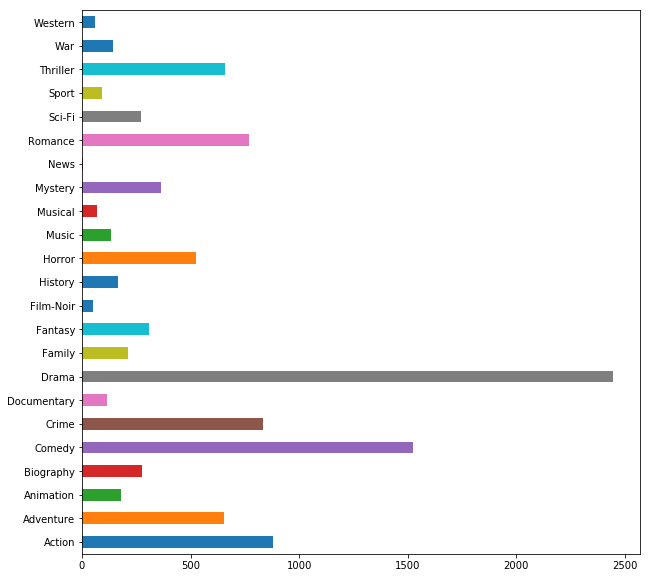

In [92]:
# TODO Change style of graphe 
# Plotting genre distribution 
genres = [item for sublist in df_films_stats["genres"] for item in sublist]
ax = pd.Series(genres).groupby(genres).count().plot.barh(figsize=(10,10))

### How is our dataset distributed through time?

Oldest movie in our dataset was released on: 1922
Newest movie in our dataset was released on: 2018


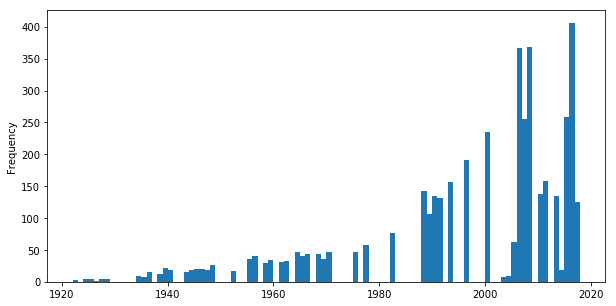

In [57]:
# TODO Change style of graphe 
print("Oldest movie in our dataset was released on: {:}".format(df_films_stats["year"].min()))
print("Newest movie in our dataset was released on: {:}".format(df_films_stats["year"].max()))
ax = df_films_stats["year"].plot.hist(bins=96, figsize=(10,5))

As we can see the data is not distributed evenly through time, a lot of years are missing and more recent films appear more. It will be then difficult to take time into account as a good metric to predict the rating given the uneven distribution

### How is the total film runtime distributed aswell?

Shortest movie in our dataset is: 45.0 minutes long
Longest movie in our dataset is: 467.0 minutes long


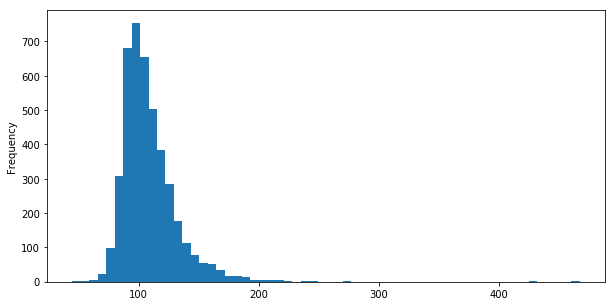

In [22]:
# TODO Change style of graphe 
print("Shortest movie in our dataset is: {:} minutes long".format(df_films_stats["runtimeMinutes"].min()))
print("Longest movie in our dataset is: {:} minutes long".format(df_films_stats["runtimeMinutes"].max()))

ax = df_films_stats["runtimeMinutes"].plot.hist(bins=60, figsize=(10,5))

Apart from some outliers, our data is well centered to the runtime value of 100 minutes.

### What about the ratings?

Worst rated movie in our dataset has: 1.7 rating
Best rated movie in our dataset has: 9.4 rating
Average rating in our dataset is 6.7


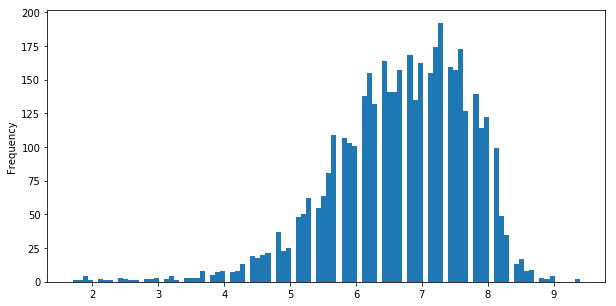

In [21]:
# TODO Change style of graphe 
print("Worst rated movie in our dataset has: {:.1f} rating".format(df_films_stats["averageRating"].min()))
print("Best rated movie in our dataset has: {:.1f} rating".format(df_films_stats["averageRating"].max()))
print("Average rating in our dataset is {:.1f}".format(df_films_stats["averageRating"].mean()))
ax = df_films_stats["averageRating"].plot.hist(bins=100, figsize=(10,5))

## Simple statistics: searching for a correlation between average IMDb rating and text features. 

To begin, some "raw" features are extracted from the subtitles and the meta-data that they were shipped with : 
* the total number of words relative to the movie duration. 
* the total number of sentences relative to the movie duration.
* the mean average length of the subtitles.
* the subtitles to movie duration ratio.
* the number of distinct words divided by the length of the movie, the total number of words and the mean average length of the sentences.

In [150]:
def word_statistics(df_films):
    # Explode the sentences t
    df_words = df_films.select('*', psf.explode('subtitles').alias('words'))
    df_words = df_words.select('*', psf.explode('words').alias('word'))
    
    df_word_counts = df_words.groupby("tconst", "num_sentences","subtitle_mins")\
                             .agg(psf.count("word")
                                     .alias("num_words"), 
                                  psf.countDistinct("word")\
                                     .alias("num_distinct_words"))\
                             .join(df_basics, ['tconst'], 'inner')\
                             .withColumn("norm_num_words",
                                         psf.col("num_words") / psf.col("runtimeMinutes"))\
                             .withColumn("norm_num_sents",
                                         psf.col("num_sentences") / psf.col("runtimeMinutes")
                                        )\
                             .withColumn("times_ratio",
                                         psf.when(psf.col("subtitle_mins").isNotNull(), 
                                                  psf.col("subtitle_mins") / psf.col("runtimeMinutes") * 100)
                                        )\
                             .withColumn("mean_length_sentences",
                                         psf.col("num_words") / psf.col("num_sentences")
                                        )\
                             .withColumn("distinct_index", 
                                         1000* psf.col("num_distinct_words") /(psf.col("num_sentences")*
                                                                         psf.col("runtimeMinutes")*
                                                                         psf.col("num_words")
                                                                        )
                                        )\
                             .withColumn("times_ratio",
                                         psf.when(psf.col("subtitle_mins").isNotNull(), 
                                                  psf.col("subtitle_mins") / psf.col("runtimeMinutes") * 100))
    
    df_word_counts = df_word_counts.select("tconst", 
                                           "num_words",
                                           "norm_num_words",
                                           "num_distinct_words",
                                           "distinct_index",
                                           "num_sentences",
                                           "norm_num_sents",
                                           "mean_length_sentences",
                                           "subtitle_mins",
                                           "runtimeMinutes", 
                                           "times_ratio", 
                                           )
    return df_word_counts

In [151]:
# load data  

# df_films = spark.read.parquet("parquets/films.parquet")

In [152]:
# Generating the df of statistics 
df_stats = word_statistics(df_films)

In [153]:
df_stats.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- num_words: long (nullable = false)
 |-- norm_num_words: double (nullable = true)
 |-- num_distinct_words: long (nullable = false)
 |-- distinct_index: double (nullable = true)
 |-- num_sentences: long (nullable = true)
 |-- norm_num_sents: double (nullable = true)
 |-- mean_length_sentences: double (nullable = true)
 |-- subtitle_mins: double (nullable = true)
 |-- runtimeMinutes: double (nullable = true)
 |-- times_ratio: double (nullable = true)



In [154]:
# Saving the df of statistics 
# df_stats.write.mode("overwrite").parquet("parquets/stats.parquet")

### Plots 

This section regroups the plots of the computed statistics to explore the data and look for particularities of what is considered a "good" movie and a "bad" movie. 

#### Conversion to pandas dataframe 

In [155]:
# Load from parquet 
df_words_stats = spark.read.parquet("parquets/stats.parquet")

In [156]:
df_basics.take(1)

[Row(tconst='tt0000001', titleType='short', primaryTitle='Carmencita', originalTitle='Carmencita', isAdult='0', startYear='1894', endYear='\\N', runtimeMinutes=1.0, genres=['Documentary', 'Short'])]

In [157]:
# join with ratings to get average rating: 
df_words_ratings = df_words_stats.join(other=df_ratings, 
                                       on='tconst', 
                                       how='inner')
# join with basics to get title:
df_words_ratings = df_words_ratings.join(other=df_basics.select('tconst',
                                           'originalTitle'), 
                                       on='tconst', 
                                       how='inner')

In [158]:
df_words_ratings_pd = df_words_ratings.toPandas()

In [ ]:
df_words_ratings_pd.head()

Using the resulting dataframe we first look at it statistics for each entry.
Then we plot each column vs the average rating to see if we find some kind of linear dependency.
We also plot the histograms of each metric for films we consider "good" and films we consider "bad" to see if we have different distributions for such metrics.

In [ ]:
print("Means:")
print(df_words_ratings_pd.mean(), "\n")
print("Medians:")
print(df_words_ratings_pd.median(), "\n")
print("Std deviations")
print(df_words_ratings_pd.std())

#### Correlations 

We compute the correlation between our

In [159]:
df_words_ratings_pd.corr()["averageRating"]

num_words                0.138906
norm_num_words           0.003646
num_distinct_words       0.114942
distinct_index           0.019917
num_sentences            0.042028
norm_num_sents          -0.106126
mean_length_sentences    0.199009
subtitle_mins            0.269166
runtimeMinutes           0.303423
times_ratio              0.210585
averageRating            1.000000
numVotes                 0.226780
Name: averageRating, dtype: float64

#### Plots for words 

In [160]:
#TODO do something for the axis 

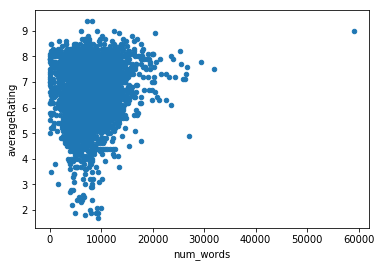

In [161]:
ax = df_words_ratings_pd.plot.scatter("num_words", "averageRating")

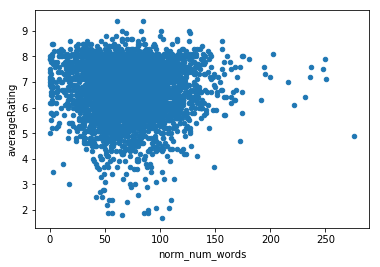

In [140]:
ax = df_words_ratings_pd.plot.scatter("norm_num_words", "averageRating")

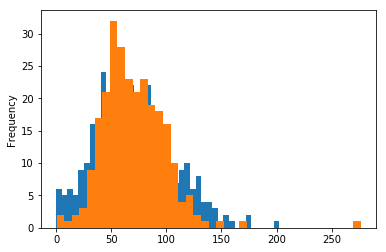

In [141]:
df_words_ratings_pd[df_words_ratings_pd.averageRating >= 8]["norm_num_words"].plot.hist(bins=40)
df_words_ratings_pd[df_words_ratings_pd.averageRating <= 5]["norm_num_words"].plot.hist(bins=40)
plt.show()

##### Comments :

Looking at the plots reveals that there is not clear distinction in the average IMDb rating based on how many subtitles are employed in a movie.

* The first plot shows that most of the film use 5'000 to 15'000 words but that does not have a significant impact on the rating.
* The idea behind a the ratio $ \frac{x}{\text{Length of Movie}}$ where $x$ here is the number of words used in the movie, is simply to take into accound that movie that is longer could have in proportion the same amount of words employed. Indeed, a longer movie is not necessarly more verbose, it could only have more words used in it because it is longer. 
* The second plot does not provide much more information than the first and actually shows data more evenly distributed. 
* Finally, to see if there is a clear distinction between what is considered a "good" (= average ratinge >= 8) and a "bad" movie (= average ratinge <= 5) we plot an histogram for both types. Again no partiucaler behaviour is noted.    

#### Plots for distinct words : 

He iterate the previous analysis but this time looking at the distinct words. What is expected is that movies that use a larger vocabulary could have been written more caustiously, leading to better scenario and hence a better movie. 

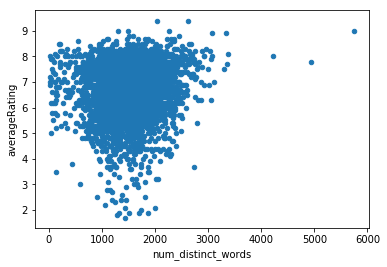

In [142]:
ax = df_words_ratings_pd.plot.scatter("num_distinct_words", "averageRating")

Again, no general trend can be seen. To bring all movies on equal footing reagrding the number of distinct words used in their subtitles, the number of distinct words is divided by : 
* the length of the movie
* the number of words used 
* the number of sentences 
and multiplied by 1000 to have larger numbers. 
The intuition is that any this three parameters could influence the distinct number of words used : 
* longer movies provide more chances to use different words
* the more words used, the more diversed they can be
* more sentences provide more occasions to employ a larger vocabulary

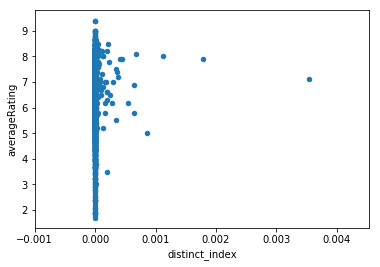

In [149]:
ax = df_words_ratings_pd.plot.scatter("distinct_index", "averageRating");
ax.set_xlim([-0.001,df_words_ratings_pd['distinct_index'].max()+0.001]);

In [148]:
df_words_ratings_pd['distinct_index'].describe()

count    4.275000e+03
mean     5.907891e-06
std      6.989477e-05
min      3.338497e-08
25%      9.235421e-07
50%      1.409777e-06
75%      2.246188e-06
max      3.537245e-03
Name: distinct_index, dtype: float64

By looking at the plote `distinct_index` vs `averageRating` and statistic description, we see that most of the movies is agglutinated to a single value as shown by the mean and the quartiles. 

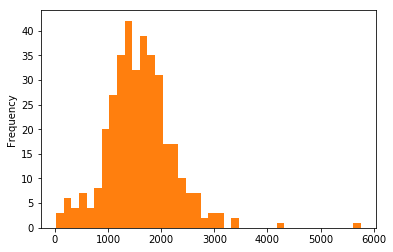

In [90]:
#TODO do something to visualize both 
df_words_ratings_pd[df_words_ratings_pd.averageRating <= 5]["num_distinct_words"].plot.hist(bins=40);
df_words_ratings_pd[df_words_ratings_pd.averageRating >= 8]["num_distinct_words"].plot.hist(bins=40);


##### Comments :

Again 

#### Plots for the number of  sentences

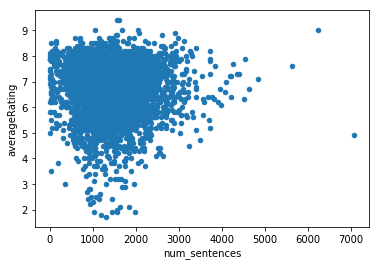

In [85]:
ax = df_words_ratings_pd.plot.scatter("num_sentences", "averageRating")

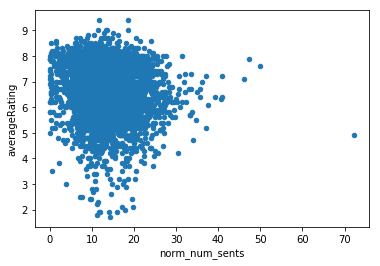

In [86]:
ax = df_words_ratings_pd.plot.scatter("norm_num_sents", "averageRating")

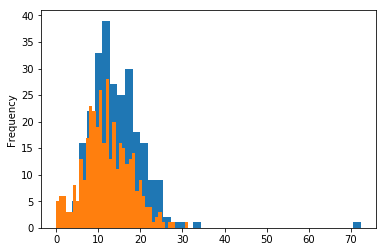

In [88]:
# TODO do somtehing to visualize both 
df_words_ratings_pd[df_words_ratings_pd.averageRating <= 5]["norm_num_sents"].plot.hist(bins=40);
df_words_ratings_pd[df_words_ratings_pd.averageRating >= 8]["norm_num_sents"].plot.hist(bins=40);

#### Plots for the mean length of sentences

In [103]:
#TODO described how mean length of sentences is computed 

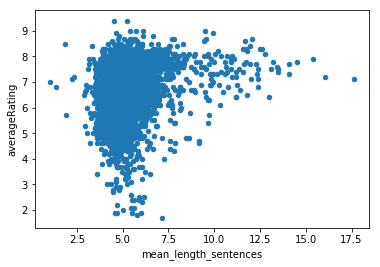

In [77]:
ax = df_words_ratings_pd.plot.scatter("mean_length_sentences", "averageRating")

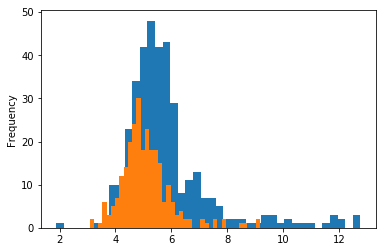

In [78]:
df_words_ratings_pd[df_words_ratings_pd.averageRating >= 8]["mean_length_sentences"].plot.hist(bins=40);
df_words_ratings_pd[df_words_ratings_pd.averageRating <= 5]["mean_length_sentences"].plot.hist(bins=40);

#### Plots for durations 

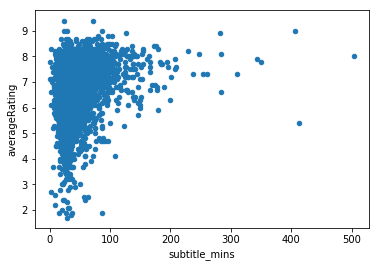

In [93]:
ax = df_words_ratings_pd.plot.scatter("subtitle_mins", "averageRating")

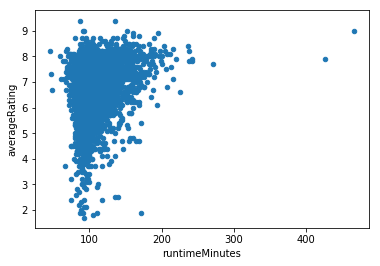

In [94]:
ax = df_words_ratings_pd.plot.scatter("runtimeMinutes", "averageRating")

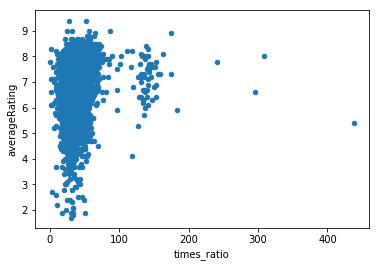

In [95]:
ax = df_words_ratings_pd.plot.scatter( "times_ratio", "averageRating")

#### to be classified 

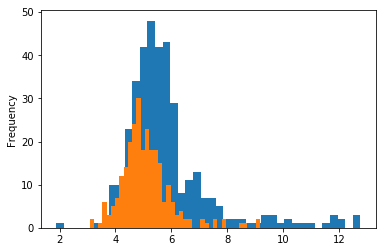

In [78]:
df_words_ratings_pd[df_words_ratings_pd.averageRating >= 8]["mean_length_sentences"].plot.hist(bins=40);
df_words_ratings_pd[df_words_ratings_pd.averageRating <= 5]["mean_length_sentences"].plot.hist(bins=40);

In [74]:
# TODO : what to do with this 
df_words_ratings_pd[df_words_ratings_pd.averageRating <= 5]["num_distinct_words"].plot.hist(bins=40);df_words_ratings_pd.iloc[df_words_ratings_pd["num_distinct_words"].idxmax()]

tconst                    tt5275892
num_words                     59152
norm_num_words              126.664
num_distinct_words             5751
distinct_index           3.3385e-08
num_sentences                  6236
norm_num_sents              13.3533
mean_length_sentences       9.48557
subtitle_mins                406.05
runtimeMinutes                  467
times_ratio                 86.9486
averageRating                     9
numVotes                      14176
Name: 4210, dtype: object

### WORD ANALYSIS

In [55]:
df_all = spark.read.parquet("parquets/words/allwords.parquet/")
df_film_words = spark.read.parquet("parquets/words/filmwords.parquet/")
df_all.sort("count", ascending=False).show()
df_film_words.sort("count", ascending=False).show()


+----+-------+
|word|  count|
+----+-------+
|   I|1304701|
| you|1074551|
| the| 906553|
|  to| 746516|
|   a| 626537|
|  it| 457048|
|  of| 382511|
|that| 363364|
| You| 361943|
| and| 344160|
|  in| 319820|
|  me| 318220|
|  is| 314460|
|  on| 230377|
| for| 219431|
|this| 209579|
|your| 202776|
|have| 201724|
|  my| 200440|
|What| 198087|
+----+-------+
only showing top 20 rows

+---------+----+-----+
|   tconst|word|count|
+---------+----+-----+
|tt5275892| the| 2380|
|tt5275892|   I| 2040|
|tt5275892|  to| 1519|
|tt0048977|   I| 1424|
|tt5275892|   a| 1343|
|tt0829482|   I| 1328|
|tt0064117|   I| 1320|
|tt0380268| the| 1295|
|tt5275892| was| 1224|
|tt5275892| and| 1224|
|tt0101912|   I| 1202|
|tt5275892|that| 1199|
|tt0031381|   I| 1180|
|tt0052415|   I| 1172|
|tt0102138| the| 1129|
|tt2318527| YOU| 1124|
|tt0478311|   I| 1115|
|tt5275892|  of| 1106|
|tt0031381| you| 1088|
|tt0058461| the| 1079|
+---------+----+-----+
only showing top 20 rows



In [58]:
nlp = spacy.load('en')
spacy_stopwords = set(spacy.lang.en.stop_words.STOP_WORDS)
df_film_words_filtered = df_film_words.filter(~psf.lower(df_film_words.word).isin(spacy_stopwords)).sort("count", ascending=False)
df_all_filtered =df_all.filter(~psf.lower(df_all.word).isin(spacy_stopwords)).sort("count", ascending=False)

Here we calculate the average word length of each word considering only non-stop words

In [59]:
df_aux_word = df_film_words_filtered.selectExpr("tconst", "length(word) * count as product", "count").groupBy("tconst")
df_word_length= df_aux_word.agg({"count": "sum", "product": "sum"})
df_word_length = df_word_length.withColumn("av_word_length", df_word_length["sum(product)"]/ df_word_length["sum(count)"])\
                                .select("tconst", "av_word_length")
df_word_length.show()

+---------+------------------+
|   tconst|    av_word_length|
+---------+------------------+
|tt0464049| 5.261352749568883|
|tt0039305|  4.98247748844001|
|tt0456165|   5.1687552213868|
|tt0383028| 5.264967540274104|
|tt1529572| 5.121131270010673|
|tt0032599| 5.331725800895625|
|tt0107840| 4.846733668341709|
|tt0100142| 5.755446516192346|
|tt1031969| 5.006596906278435|
|tt0102216|5.5913200723327305|
|tt0066193|5.1925498426023085|
|tt3531824| 4.718718718718718|
|tt1280558| 5.468712394705174|
|tt0117718|  5.02393523407251|
|tt1640548| 5.287601626016261|
|tt0204946| 5.376195028680688|
|tt0036323| 5.186022253129346|
|tt1602476| 5.202265005662515|
|tt2980210|5.4265878877400295|
|tt0449010| 5.470213996529786|
+---------+------------------+
only showing top 20 rows



In [60]:
df_word_length_pd = df_word_length.join(df_ratings, ["tconst"]).toPandas()

0.15255192780928192

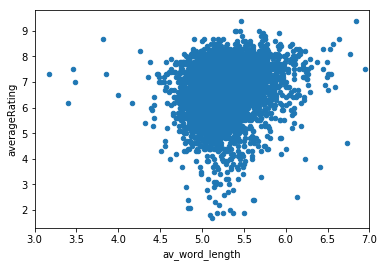

In [61]:
ax = df_word_length_pd.plot.scatter("av_word_length", "averageRating")
df_word_length_pd.iloc[df_word_length_pd["av_word_length"].idxmax()]
plt.xlim(3,7)
df_word_length_pd["av_word_length"].corr(df_word_length_pd["averageRating"])

# Trying to predict the IMDb average rating:

Even though we don't see a big dependency between the statistics found and the movie rating, we'll try to do a regression model based on them to see its accuracy, how well it predicts the rating. We don't expect a good result from the exploration performed before.

In [64]:
feature_columns = df_words_ratings_pd.columns[1:-2]
X = df_words_ratings_pd[feature_columns]
normal_X = (X- X.mean()) /X.std()
normal_X = normal_X.fillna(0)
y = df_words_ratings_pd["averageRating"]

In [65]:
regression = LinearRegression()
predicted = cross_val_predict(regression, normal_X, y, cv=5)

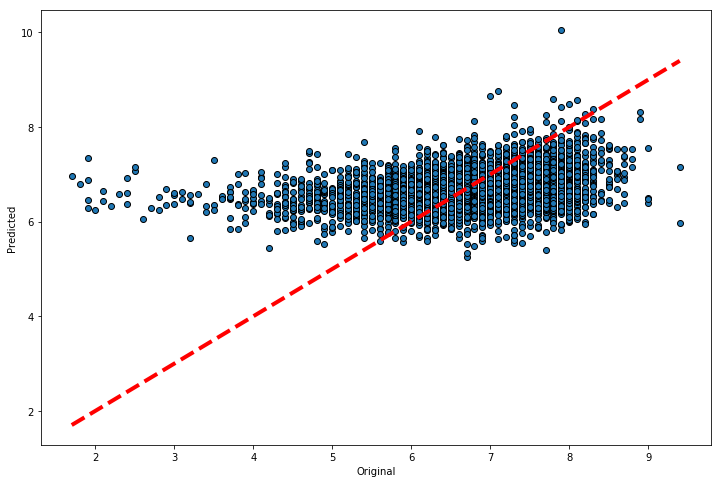

In [66]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([min(y), max(y)], [min(y), max(y)], 'r--', lw=4)
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

As we can see and expected... no real causation, if we arbitrarily consider a good film one with more than 8 as rating, lets try and see if a logistic regression performs better. We don't expect the model to perform any better.

In [67]:
y = y.map(lambda x: 1 if x>= 8 else 0)

In [68]:
regression = LogisticRegression(solver='lbfgs')
precision = cross_val_score(regression, normal_X, y, cv=10, scoring="precision")
recall = cross_val_score(regression, normal_X, y, cv=10, scoring="recall")

# Precision: avoid false positives
print("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
# Recall: avoid false negatives
print("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))

C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision: 0.33 (+/- 0.89)
Recall: 0.02 (+/- 0.05)


Again we can see, the results are what we expected, no accurate prediction can be given from the given statistics

These plots show us little relation between the found metrics and the actual film rating, the only thing we could state is that films with more text tend to be better rated. We now look at the different genres.


## Genre Exploration

Here we find the average rating for the 10 most represented genres.

In [69]:
df_genres = df_films.drop("subtitles").join(df_basics.select("tconst", "genres", "primaryTitle", "runtimeMinutes"), ["tconst"])
df_genres= df_genres.join(df_ratings, ["tconst"])
         

In [71]:
df_genres_avRating = df_genres.select('*', psf.explode('genres').alias('genre')).groupBy("genre").agg({"averageRating": "mean", "*": "count"})
df_genres_rating_pd = df_genres_avRating.sort("count(1)", ascending=False).limit(10).toPandas()

We can see that there are no very big differences between genres apparently, though we can see that a Drama movie is more likely to have a good rating than a horror movie. From these statistics we could assume that the genre has somehow an influence in the film's average rating.


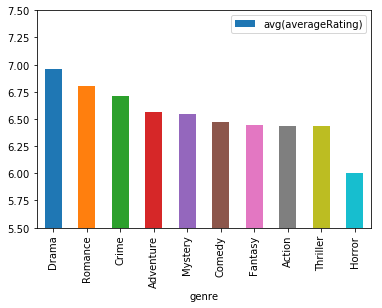

In [72]:
df_genres_rating_pd.sort_values("avg(averageRating)", ascending=False).plot.bar(y="avg(averageRating)", x="genre")
plt.ylim(5.5, 7.5)
plt.show()

## Time Exploration

We categorize our films into 3 time periods

In [79]:
def add_time_period(year):
    if year < 1910 or year > 2018:
        return "NaN"
    elif year < 1960:
        return "1910-1950's"
    elif year < 2000:
        return "1960-1990's"
    else:
        return "2000's"
udf_period = psf.udf(add_time_period, StringType())    


In [80]:
df_words_ratings_periods = df_words_ratings.join(df_films.select("year", "tconst"), ["tconst"]).withColumn("period", udf_period("year"))
df_words_ratings_periods.groupBy("period").count().show()

+-----------+-----+
|     period|count|
+-----------+-----+
|1960-1990's| 1361|
|1910-1950's|  383|
|     2000's| 2542|
+-----------+-----+



Not very balanced

In [81]:
df_words_ratings_periods.groupBy("period").agg({"averageRating": "mean"}).show()

+-----------+------------------+
|     period|avg(averageRating)|
+-----------+------------------+
|1960-1990's| 6.829757543980068|
|1910-1950's| 7.587206303295205|
|     2000's| 6.470495676637915|
+-----------+------------------+



Are films getting worse? Can't be sure as the amount of films is not big enough but from our data it would seem so

Check distributions for each time period

In [82]:
df_periods_stats = df_words_ratings_periods.join(df_genres.select("tconst", psf.explode('genres').alias('genre')), ["tconst"])\
                        .groupBy("period", "genre").agg({"averageRating": "mean", "*": "count"})
df_periods_stats_pd = df_periods_stats.toPandas()

In [83]:
df_genres = df_films.drop("subtitles").join(df_basics.select("tconst", "genres", "primaryTitle", "runtimeMinutes"), ["tconst"])
df_genres= df_genres.join(df_ratings, ["tconst"])
         

#### Subtitles to String and time period separation functions

In [84]:
df_periods_stats_pd[df_periods_stats_pd["count(1)"] > 100].sort_values("avg(averageRating)", ascending=False)

,period,genre,avg(averageRating),count(1)
15,1910-1950's,Drama,7.636060,269
53,1910-1950's,Romance,7.595000,120
18,2000's,Biography,7.151351,185
60,1960-1990's,Drama,7.139177,753
23,1960-1990's,Romance,6.943056,216
39,2000's,Drama,6.735992,1442
49,1960-1990's,Crime,6.735563,284
36,1960-1990's,Thriller,6.734973,183
40,1960-1990's,Adventure,6.689202,213
56,2000's,Animation,6.614706,136


## Text analysis

TODO: Use parquet with marks.

In [98]:
df_films_strings = spark.read.parquet("parquets/filmtext.parquet/")

In [99]:
df_films_strings.show()

Py4JJavaError: An error occurred while calling o471.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 32.0 failed 1 times, most recent failure: Lost task 0.0 in stage 32.0 (TID 712, localhost, executor driver): TaskResultLost (result lost from block manager)
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1651)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1639)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1638)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1638)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1872)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1821)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1810)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:363)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3278)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2489)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2489)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3259)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3258)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2489)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2703)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:254)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Unknown Source)


### SENTIMENT ANALYSIS. 
TODO do it on the best and worst films. Get average positive sentiment. NEED PUNCTUATION MARKS

In [95]:
df_strings = df_films_strings.join(df_ratings, ["tconst"]).toPandas()

Py4JJavaError: An error occurred while calling o375.collectToPython.
: org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:205)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec.doExecuteBroadcast(BroadcastExchangeExec.scala:136)
	at org.apache.spark.sql.execution.InputAdapter.doExecuteBroadcast(WholeStageCodegenExec.scala:367)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeBroadcast$1.apply(SparkPlan.scala:144)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeBroadcast$1.apply(SparkPlan.scala:140)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.executeBroadcast(SparkPlan.scala:140)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.prepareBroadcast(BroadcastHashJoinExec.scala:135)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.codegenInner(BroadcastHashJoinExec.scala:232)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.doConsume(BroadcastHashJoinExec.scala:102)
	at org.apache.spark.sql.execution.CodegenSupport$class.consume(WholeStageCodegenExec.scala:181)
	at org.apache.spark.sql.execution.ProjectExec.consume(basicPhysicalOperators.scala:35)
	at org.apache.spark.sql.execution.ProjectExec.doConsume(basicPhysicalOperators.scala:65)
	at org.apache.spark.sql.execution.CodegenSupport$class.consume(WholeStageCodegenExec.scala:181)
	at org.apache.spark.sql.execution.FilterExec.consume(basicPhysicalOperators.scala:85)
	at org.apache.spark.sql.execution.FilterExec.doConsume(basicPhysicalOperators.scala:206)
	at org.apache.spark.sql.execution.CodegenSupport$class.consume(WholeStageCodegenExec.scala:181)
	at org.apache.spark.sql.execution.FileSourceScanExec.consume(DataSourceScanExec.scala:158)
	at org.apache.spark.sql.execution.ColumnarBatchScan$class.produceBatches(ColumnarBatchScan.scala:138)
	at org.apache.spark.sql.execution.ColumnarBatchScan$class.doProduce(ColumnarBatchScan.scala:78)
	at org.apache.spark.sql.execution.FileSourceScanExec.doProduce(DataSourceScanExec.scala:158)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:88)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.FileSourceScanExec.produce(DataSourceScanExec.scala:158)
	at org.apache.spark.sql.execution.FilterExec.doProduce(basicPhysicalOperators.scala:125)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:88)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.FilterExec.produce(basicPhysicalOperators.scala:85)
	at org.apache.spark.sql.execution.ProjectExec.doProduce(basicPhysicalOperators.scala:45)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:88)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.ProjectExec.produce(basicPhysicalOperators.scala:35)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.doProduce(BroadcastHashJoinExec.scala:97)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:88)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.produce(BroadcastHashJoinExec.scala:39)
	at org.apache.spark.sql.execution.ProjectExec.doProduce(basicPhysicalOperators.scala:45)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:88)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.ProjectExec.produce(basicPhysicalOperators.scala:35)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doCodeGen(WholeStageCodegenExec.scala:524)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:576)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan.getByteArrayRdd(SparkPlan.scala:247)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:294)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3200)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3197)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3259)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3258)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3197)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 27.0 failed 1 times, most recent failure: Lost task 0.0 in stage 27.0 (TID 698, localhost, executor driver): TaskResultLost (result lost from block manager)
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1651)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1639)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1638)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1638)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1872)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1821)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1810)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.sql.execution.SparkPlan.executeCollectIterator(SparkPlan.scala:304)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec$$anonfun$relationFuture$1$$anonfun$apply$1.apply(BroadcastExchangeExec.scala:76)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec$$anonfun$relationFuture$1$$anonfun$apply$1.apply(BroadcastExchangeExec.scala:73)
	at org.apache.spark.sql.execution.SQLExecution$.withExecutionId(SQLExecution.scala:97)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec$$anonfun$relationFuture$1.apply(BroadcastExchangeExec.scala:72)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec$$anonfun$relationFuture$1.apply(BroadcastExchangeExec.scala:72)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more


In [ ]:
nalyzer = SentimentIntensityAnalyzer()
def av_sentiment_film(text):
    document = nlp(text)
    positive_sent = 0
    negative_sent = 0
    sents = document.sents
    count = 0
    for sent in sents:
        positive_sent += analyzer.polarity_scores(sent.text)['pos']
        negative_sent += analyzer.polarity_scores(sent.text)['neg']
        count += 1
    return (positive_sent - negative_sent) / count


In [ ]:
#TODO CHoose number of subtitles,
#df_strings["av_sentiment"] = df_strings["text"].apply(av_sentiment_film)